# BTCUSDT (1h) — Public Binance Data EDA
This notebook:
- Loads spot/futures-related public datasets you've exported (1h resolution where available)
- Aligns everything to an hourly UTC grid
- Computes 1h log-returns from futures close
- Explores data with `.head()`, `.describe()`, missingness, and rich plots (Seaborn + Matplotlib)
- Saves a merged dataset for downstream modeling

> Data sources (as CSVs in the working directory):
> - `BTCUSDT_fapi_klines_1h.csv` — Perp futures OHLCV (1h)
> - `BTCUSDT_premiumIndexKlines_1h.csv` — Premium index klines (perp–spot basis proxy)
> - `BTCUSDT_fundingRate.csv` — Funding rate history
> - `BTCUSDT_takerBuySellVol_1h.csv` — Taker flow (buy/sell) stats (≈ last 30 days)
> - `BTCUSDT_openInterestHist_1h.csv` — Open interest history (1h)
> - `BTCUSDT_openInterest_now.csv` — OI snapshot (optional)



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 200)

sns.set_theme()

In [2]:
# Paths
DATA_DIR = "data/raw"
paths = {
    "klines_1h": os.path.join(DATA_DIR, "BTCUSDT_fapi_klines_1h.csv"),
    "premium_1h": os.path.join(DATA_DIR, "BTCUSDT_premiumIndexKlines_1h.csv"),
    "funding": os.path.join(DATA_DIR, "BTCUSDT_fundingRate.csv"),
    "taker_1h": os.path.join(DATA_DIR, "BTCUSDT_takerBuySellVol_1h.csv"),
    "oi_hist_1h": os.path.join(DATA_DIR, "BTCUSDT_openInterestHist_1h.csv"),
    "oi_now": os.path.join(DATA_DIR, "BTCUSDT_openInterest_now.csv"),
}


In [3]:
def read_klines_like(path):
    """Read klines-like CSV (with/without headers).
    Fallback to standard 12-column Binance layout if unnamed."""
    if not os.path.exists(path):
        print(f"[read_klines_like] Missing: {path}")
        return pd.DataFrame()
    
    df = pd.read_csv(path)

    for c in ["open","high","low","close","volume","quote_volume","taker_buy_base","taker_buy_quote"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    for c in ["open_time","close_time"]:
        if c in df.columns:
            ser = pd.to_numeric(df[c], errors="coerce")
            if ser.dropna().empty:
                df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)
            else:
                unit = "ms" if ser.max() > 10**11 else "s"
                df[c] = pd.to_datetime(ser, unit=unit, utc=True)
    return df.sort_values("open_time").reset_index(drop=True)

def read_taker_vol(path):
    """Read taker buy/sell volume stats (ratio)."""
    if not os.path.exists(path):
        print(f"[read_taker_vol] Missing: {path}")
        return pd.DataFrame()

    df = pd.read_csv(path)

    if "timestamp" in df.columns:
        ts = pd.to_numeric(df["timestamp"], errors="coerce")
        if ts.dropna().empty:
            df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
        else:
            unit = "ms" if ts.max() > 10**11 else "s"
            df["timestamp"] = pd.to_datetime(ts, unit=unit, utc=True)

    for c in ["buyVol","sellVol","buySellRatio"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.sort_values("timestamp").reset_index(drop=True)

def read_funding(path):
    """Read funding rate history (GET /fapi/v1/fundingRate export)."""
    if not os.path.exists(path):
        print(f"[read_funding] Missing: {path}")
        return pd.DataFrame()

    df = pd.read_csv(path)
            
    ser = pd.to_numeric(df["fundingTime"], errors="coerce")
    if ser.dropna().empty:
        df["fundingTime"] = pd.to_datetime(df["fundingTime"], errors="coerce", utc=True)
    else:
        unit = "ms" if ser.max() > 10**11 else "s"
        df["fundingTime"] = pd.to_datetime(ser, unit=unit, utc=True)
    for c in ["fundingRate","markPrice"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.sort_values("fundingTime").reset_index(drop=True)

def read_oi_hist(path):
    """Read open interest history (sumOpenInterest, sumOpenInterestValue)."""

    if not os.path.exists(path):
        print(f"[read_oi_hist] Missing: {path}")
        return pd.DataFrame()

    df = pd.read_csv(path)


    if "timestamp" not in df.columns:
        if df.shape[1] >= 3:
            df = df.iloc[:, :3]
            df.columns = ["timestamp","sumOpenInterest","sumOpenInterestValue"]
    if "timestamp" in df.columns:
        ts = pd.to_numeric(df["timestamp"], errors="coerce")
        if ts.dropna().empty:
            df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
        else:
            unit = "ms" if ts.max() > 10**11 else "s"
            df["timestamp"] = pd.to_datetime(ts, unit=unit, utc=True)
    for c in ["sumOpenInterest","sumOpenInterestValue"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.sort_values("timestamp").reset_index(drop=True)

def read_oi_now(path):
    if not os.path.exists(path):
        print(f"[read_oi_now] Missing: {path}")
        return pd.DataFrame()

    df = pd.read_csv(path)
    
    if "openInterest" in df.columns:
        df["openInterest"] = pd.to_numeric(df["openInterest"], errors="coerce")
    return df


In [4]:
# Load all datasets
df_k = read_klines_like(paths["klines_1h"])
df_prem = read_klines_like(paths["premium_1h"])
df_fund = read_funding(paths["funding"])
df_taker = read_taker_vol(paths["taker_1h"])
df_oi = read_oi_hist(paths["oi_hist_1h"])
df_oi_now = read_oi_now(paths["oi_now"])

print("Shapes:", {
    "klines_1h": df_k.shape,
    "premium_1h": df_prem.shape,
    "funding": df_fund.shape,
    "taker_1h": df_taker.shape,
    "oi_hist_1h": df_oi.shape,
    "oi_now": df_oi_now.shape,
})


Shapes: {'klines_1h': (24883, 12), 'premium_1h': (24883, 12), 'funding': (3111, 4), 'taker_1h': (500, 4), 'oi_hist_1h': (500, 5), 'oi_now': (1, 3)}


In [5]:
# Align to hourly timestamps, compute 1h log-returns
if not df_k.empty:
    df_k = df_k.drop_duplicates(subset=["open_time"]).sort_values("open_time").reset_index(drop=True)
    df_k["ts"] = df_k["open_time"].dt.floor("h")
    df_k["log_price"] = np.log(df_k["close"])
    df_k["log_ret_1h"] = df_k["log_price"].diff(1)

if not df_prem.empty:
    df_prem = df_prem.drop_duplicates(subset=["open_time"]).sort_values("open_time").reset_index(drop=True)
    df_prem["ts"] = df_prem["open_time"].dt.floor("h")
    df_prem.rename(columns={"close":"premium_close"}, inplace=True)

if not df_fund.empty:
    df_fund = df_fund.drop_duplicates(subset=["fundingTime"]).sort_values("fundingTime").reset_index(drop=True)
    df_fund["ts"] = df_fund["fundingTime"].dt.floor("h")

if not df_taker.empty:
    df_taker = df_taker.drop_duplicates(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
    df_taker["ts"] = df_taker["timestamp"].dt.floor("h")
    # Handy extras:
    if set(["buyVol","sellVol"]).issubset(df_taker.columns):
        total = (df_taker["buyVol"] + df_taker["sellVol"]).replace(0, np.nan)
        df_taker["taker_imbalance"] = df_taker["buyVol"] / total  # in [0,1]

if not df_oi.empty:
    df_oi = df_oi.drop_duplicates(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
    df_oi["ts"] = df_oi["timestamp"].dt.floor("h")


In [6]:
# Merge all features on hourly 'ts' (left-join to klines timeline)
if not df_k.empty:
    merged = df_k[["ts","open","high","low","close","volume","quote_volume","num_trades","taker_buy_base","taker_buy_quote","log_ret_1h"]].copy()
    if not df_prem.empty:
        merged = merged.merge(df_prem[["ts","premium_close"]], on="ts", how="left")
    if not df_fund.empty:
        fund_cols = ["ts"] + [c for c in ["fundingRate","markPrice"] if c in df_fund.columns]
        merged = merged.merge(df_fund[fund_cols], on="ts", how="left")
    if not df_taker.empty:
        taker_cols = [c for c in ["buyVol","sellVol","buySellRatio","taker_imbalance"] if c in df_taker.columns]
        merged = merged.merge(df_taker[["ts"] + taker_cols], on="ts", how="left")
    if not df_oi.empty:
        oi_cols = [c for c in ["sumOpenInterest","sumOpenInterestValue"] if c in df_oi.columns]
        merged = merged.merge(df_oi[["ts"] + oi_cols], on="ts", how="left")
    merged = merged.sort_values("ts").reset_index(drop=True)
else:
    merged = pd.DataFrame()

print("Merged shape:", merged.shape)
display(merged.head(10))


Merged shape: (24883, 20)


,ts,open,high,low,close,volume,quote_volume,num_trades,taker_buy_base,taker_buy_quote,log_ret_1h,premium_close,fundingRate,markPrice,buyVol,sellVol,buySellRatio,taker_imbalance,sumOpenInterest,sumOpenInterestValue
0,2023-01-01 00:00:00+00:00,16537.5,16540.9,16504.0,16527.0,5381.399,8.892309e+07,31529,2541.791,4.200065e+07,NaN,-0.000222,0.0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01 01:00:00+00:00,16527.1,16554.3,16524.1,16550.4,3210.826,5.309855e+07,19787,1933.859,3.198225e+07,0.001415,-0.000059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-01 02:00:00+00:00,16550.5,16557.1,16534.8,16542.4,2399.668,3.970466e+07,15720,1156.721,1.913896e+07,-0.000483,-0.000386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-01 03:00:00+00:00,16542.5,16542.5,16515.0,16529.3,3214.480,5.312060e+07,19341,1430.403,2.363773e+07,-0.000792,-0.000271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-01 04:00:00+00:00,16529.2,16530.4,16508.8,16517.8,3150.954,5.204823e+07,20937,1583.098,2.615013e+07,-0.000696,-0.000246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2023-01-01 05:00:00+00:00,16517.8,16531.1,16508.0,16525.7,3268.293,5.397691e+07,18908,1578.995,2.607945e+07,0.000478,-0.000319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2023-01-01 06:00:00+00:00,16525.6,16545.7,16525.6,16535.3,2726.582,4.509026e+07,17606,1340.462,2.216728e+07,0.000581,-0.000416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2023-01-01 07:00:00+00:00,16535.3,16537.5,16488.0,16519.6,8852.672,1.461664e+08,36399,3911.189,6.458055e+07,-0.000950,-0.000435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2023-01-01 08:00:00+00:00,16519.5,16524.9,16502.0,16504.2,3289.761,5.432034e+07,21586,1313.228,2.168359e+07,-0.000933,-0.000565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2023-01-01 09:00:00+00:00,16504.3,16536.1,16496.8,16532.7,3948.702,6.521723e+07,26147,2127.739,3.514400e+07,0.001725,-0.000408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
display(df_k.head(5))
display(df_k[["open","high","low","close","volume","quote_volume","num_trades","taker_buy_base","taker_buy_quote","log_ret_1h"]].describe())


,open_time,open,high,low,close,volume,close_time,quote_volume,num_trades,taker_buy_base,taker_buy_quote,ignore,ts,log_price,log_ret_1h
0,2023-01-01 00:00:00+00:00,16537.5,16540.9,16504.0,16527.0,5381.399,2023-01-01 00:59:59.999000+00:00,8.892309e+07,31529,2541.791,4.200065e+07,0,2023-01-01 00:00:00+00:00,9.712751,NaN
1,2023-01-01 01:00:00+00:00,16527.1,16554.3,16524.1,16550.4,3210.826,2023-01-01 01:59:59.999000+00:00,5.309855e+07,19787,1933.859,3.198225e+07,0,2023-01-01 01:00:00+00:00,9.714166,0.001415
2,2023-01-01 02:00:00+00:00,16550.5,16557.1,16534.8,16542.4,2399.668,2023-01-01 02:59:59.999000+00:00,3.970466e+07,15720,1156.721,1.913896e+07,0,2023-01-01 02:00:00+00:00,9.713682,-0.000483
3,2023-01-01 03:00:00+00:00,16542.5,16542.5,16515.0,16529.3,3214.480,2023-01-01 03:59:59.999000+00:00,5.312060e+07,19341,1430.403,2.363773e+07,0,2023-01-01 03:00:00+00:00,9.712890,-0.000792
4,2023-01-01 04:00:00+00:00,16529.2,16530.4,16508.8,16517.8,3150.954,2023-01-01 04:59:59.999000+00:00,5.204823e+07,20937,1583.098,2.615013e+07,0,2023-01-01 04:00:00+00:00,9.712194,-0.000696


,open,high,low,close,volume,quote_volume,num_trades,taker_buy_base,taker_buy_quote,log_ret_1h
count,24883.000000,24883.000000,24883.000000,24883.000000,24883.000000,2.488300e+04,2.488300e+04,24883.000000,2.488300e+04,24882.000000
mean,63898.368296,64111.422039,63680.861568,63902.117434,12175.027418,6.429285e+08,1.463121e+05,6056.815964,3.194621e+08,0.000076
std,32000.352231,32093.728818,31904.973783,32000.285243,15471.982846,7.202140e+08,1.354543e+05,7758.618711,3.591690e+08,0.004991
min,16504.300000,16524.900000,16488.000000,16504.200000,240.996000,1.980208e+07,1.061500e+04,120.227000,1.042956e+07,-0.064628
25%,29918.000000,30011.100000,29853.300000,29918.800000,4246.204500,2.419166e+08,6.686200e+04,2085.486000,1.191633e+08,-0.001876
50%,62888.300000,63122.300000,62672.400000,62889.000000,7381.344000,4.167501e+08,1.049490e+05,3671.763000,2.068112e+08,0.000064
75%,95563.500000,95886.350000,95214.900000,95565.850000,14058.200000,7.643573e+08,1.765585e+05,7005.352000,3.792602e+08,0.002070
max,125986.100000,126208.500000,125185.100000,125986.000000,355275.447000,1.448088e+10,2.742106e+06,183487.620000,7.216176e+09,0.054145


In [8]:

display(df_prem[["ts","premium_close"]].head(5))
display(df_prem[["premium_close"]].describe())


,ts,premium_close
0,2023-01-01 00:00:00+00:00,-0.000222
1,2023-01-01 01:00:00+00:00,-0.000059
2,2023-01-01 02:00:00+00:00,-0.000386
3,2023-01-01 03:00:00+00:00,-0.000271
4,2023-01-01 04:00:00+00:00,-0.000246


,premium_close
count,24883.000000
mean,-0.000219
std,0.000439
min,-0.008159
25%,-0.000485
50%,-0.000385
75%,-0.000137
max,0.004265


In [9]:

display(df_fund[["ts","fundingRate"]].head(5))
display(df_fund[["fundingRate"]].describe())

,ts,fundingRate
0,2023-01-01 00:00:00+00:00,0.000100
1,2023-01-01 16:00:00+00:00,0.000007
2,2023-01-02 00:00:00+00:00,-0.000015
3,2023-01-03 16:00:00+00:00,0.000033
4,2023-01-04 00:00:00+00:00,0.000065


,fundingRate
count,2161.000000
mean,0.000084
std,0.000096
min,-0.000122
25%,0.000032
50%,0.000086
75%,0.000100
max,0.000881


In [ ]:
cols = [c for c in ["buyVol","sellVol","buySellRatio","taker_imbalance"] if c in df_taker.columns]

display(df_taker[["ts"] + cols].head(5))
display(df_taker[cols].describe())

,ts,buyVol,sellVol,buySellRatio,taker_imbalance
0,2025-10-12 22:00:00+00:00,6962.476,7133.277,0.9761,0.493941
1,2025-10-12 23:00:00+00:00,3059.246,4324.438,0.7074,0.414325
2,2025-10-13 00:00:00+00:00,5595.236,5852.918,0.9560,0.488746
3,2025-10-13 01:00:00+00:00,3924.763,4169.937,0.9412,0.484856
4,2025-10-13 02:00:00+00:00,3526.730,4297.663,0.8206,0.450735


,buyVol,sellVol,buySellRatio,taker_imbalance
count,500.000000,500.000000,500.000000,500.000000
mean,2999.713412,3109.510248,0.991522,0.492161
std,2614.419893,2741.017831,0.215274,0.053602
min,274.966000,277.949000,0.377700,0.274133
25%,1327.723000,1373.720750,0.835650,0.455243
50%,2079.464000,2192.375000,0.965950,0.491347
75%,3858.840750,4025.892000,1.123550,0.529089
max,16800.438000,19354.256000,1.908200,0.656145


In [ ]:
cols = [c for c in ["sumOpenInterest","sumOpenInterestValue"] if c in df_oi.columns]
display(df_oi[["ts"] + cols].head(5))
display(df_oi[cols].describe())


,ts,sumOpenInterest,sumOpenInterestValue
0,2025-10-12 23:00:00+00:00,75857.207,8.735769e+09
1,2025-10-13 00:00:00+00:00,75918.435,8.722603e+09
2,2025-10-13 01:00:00+00:00,75943.671,8.750237e+09
3,2025-10-13 02:00:00+00:00,76204.867,8.812186e+09
4,2025-10-13 03:00:00+00:00,76845.381,8.857683e+09


,sumOpenInterest,sumOpenInterestValue
count,500.000000,5.000000e+02
mean,78932.717446,8.733493e+09
std,2287.100248,2.766446e+08
min,72566.537000,7.953995e+09
25%,77320.359000,8.570716e+09
50%,78579.406500,8.734044e+09
75%,80628.703500,8.868064e+09
max,85200.788000,9.583998e+09


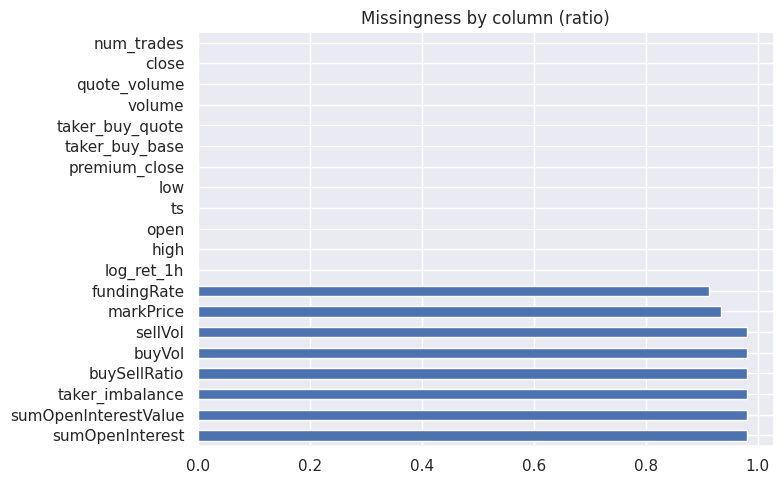

,na_ratio
sumOpenInterest,0.979906
sumOpenInterestValue,0.979906
taker_imbalance,0.979906
buySellRatio,0.979906
buyVol,0.979906
sellVol,0.979906
markPrice,0.934212
fundingRate,0.913194
log_ret_1h,0.000040
high,0.000000


In [12]:
# Missingness overview
na_ratio = merged.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
na_ratio.plot(kind="barh")
plt.title("Missingness by column (ratio)")
plt.tight_layout()
plt.show()
display(na_ratio.to_frame("na_ratio"))


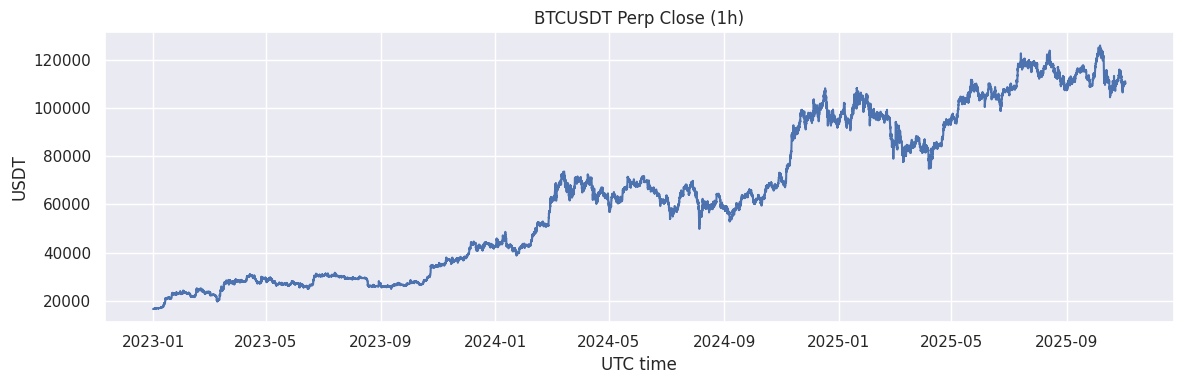

In [13]:
# Price time series
if not df_k.empty:
    plt.figure(figsize=(12,4))
    plt.plot(df_k["ts"], df_k["close"])
    plt.title("BTCUSDT Perp Close (1h)"); plt.xlabel("UTC time"); plt.ylabel("USDT")
    plt.tight_layout(); plt.show()


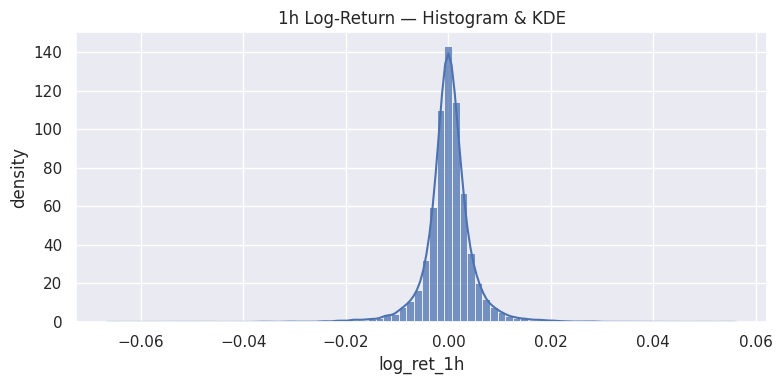

In [14]:

# Log-return histogram + KDE
s = df_k["log_ret_1h"].dropna()
plt.figure(figsize=(8,4))
sns.histplot(s, bins=80, stat="density", edgecolor=None)
sns.kdeplot(s, lw=1.5)
plt.title("1h Log-Return — Histogram & KDE"); plt.xlabel("log_ret_1h"); plt.ylabel("density")
plt.tight_layout(); plt.show()


Nice distribution
Looks like there is not so many outliers

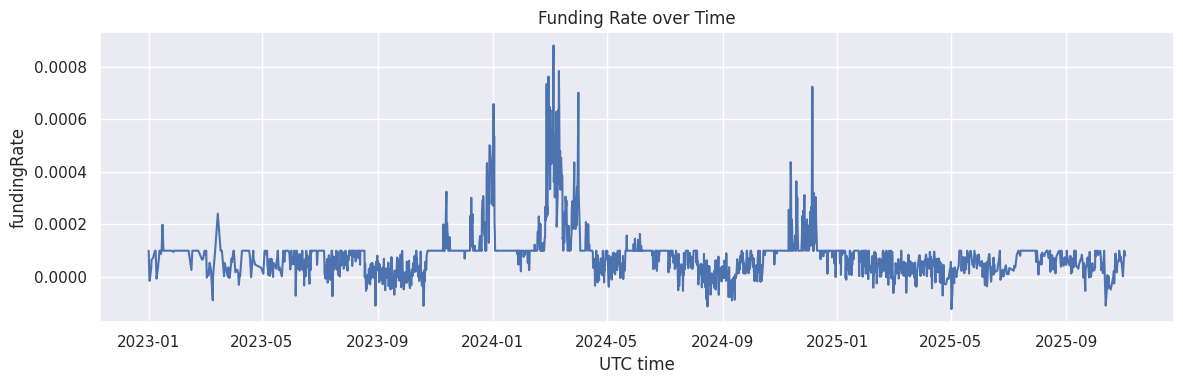

In [23]:
# Funding rate over time
plt.figure(figsize=(12,4))
sns.lineplot(x="ts", y="fundingRate", data=df_fund)
plt.title("Funding Rate over Time"); plt.xlabel("UTC time"); plt.ylabel("fundingRate")
plt.tight_layout(); plt.show()


shows what's better: short or longs


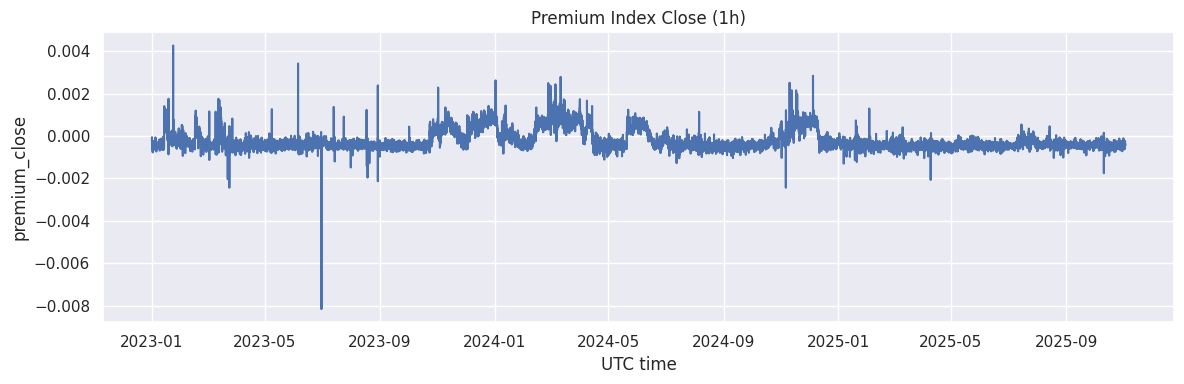

In [16]:

# Premium index close

plt.figure(figsize=(12,4))
sns.lineplot(x="ts", y="premium_close", data=df_prem)
plt.title("Premium Index Close (1h)"); plt.xlabel("UTC time"); plt.ylabel("premium_close")
plt.tight_layout(); plt.show()


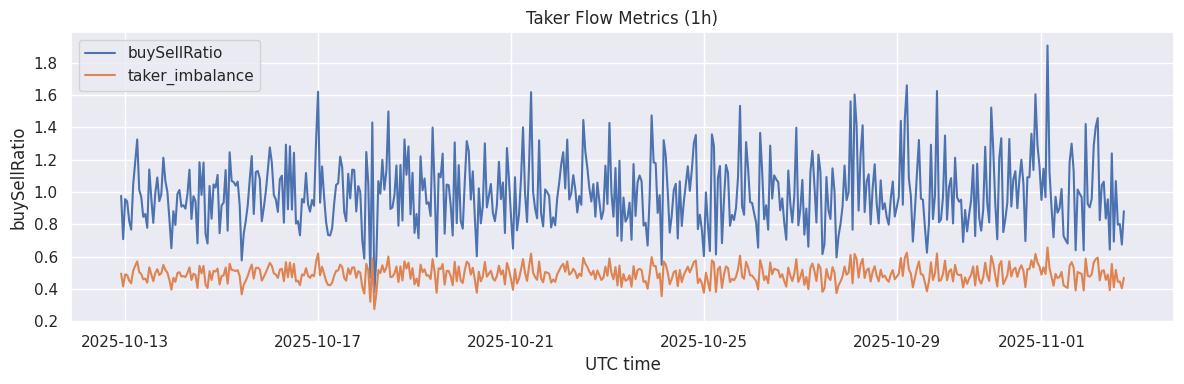

In [17]:

# Taker buy/sell ratio (and imbalance)
plt.figure(figsize=(12,4))

sns.lineplot(x="ts", y="buySellRatio", data=df_taker, label="buySellRatio")

sns.lineplot(x="ts", y="taker_imbalance", data=df_taker, label="taker_imbalance")
plt.title("Taker Flow Metrics (1h)"); plt.xlabel("UTC time")
plt.tight_layout(); plt.show()


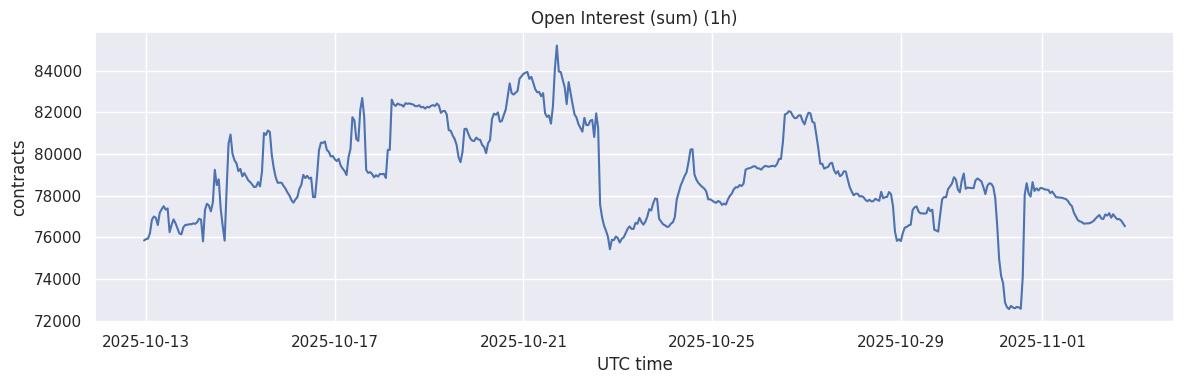

In [18]:

# Open interest

plt.figure(figsize=(12,4))
sns.lineplot(x="ts", y="sumOpenInterest", data=df_oi)
plt.title("Open Interest (sum) (1h)"); plt.xlabel("UTC time"); plt.ylabel("contracts")
plt.tight_layout(); plt.show()


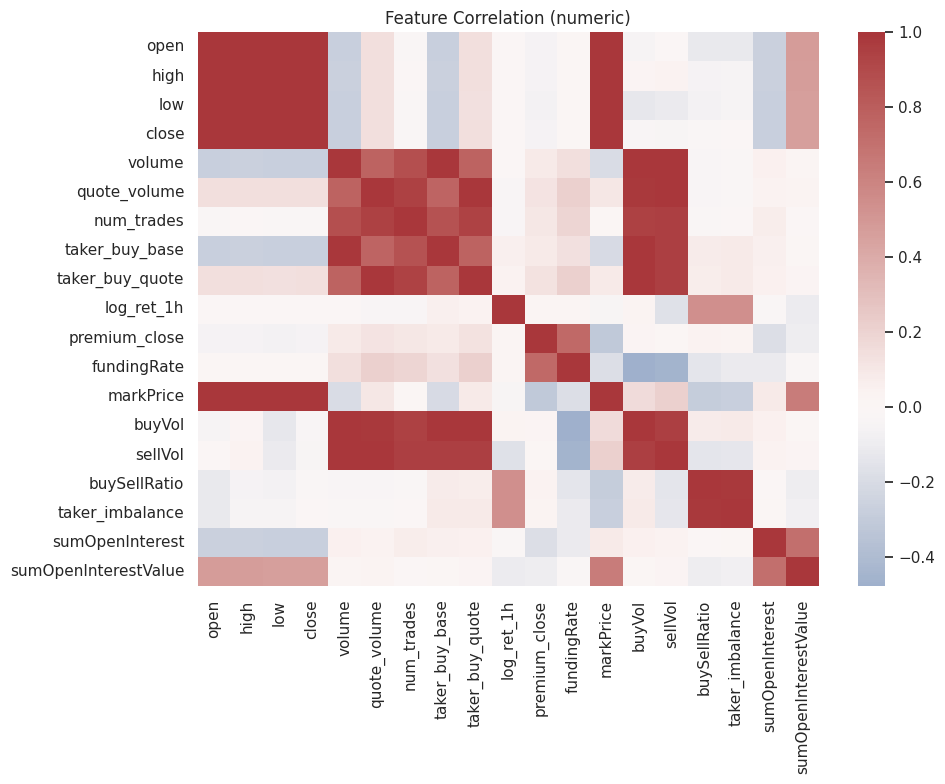

In [19]:
# Correlation heatmap & pairplot
num_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
corr = merged[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="vlag", center=0)
plt.title("Feature Correlation (numeric)")
plt.tight_layout(); plt.show()


Looks like many features are correleted. This is expected, will use k-fold to determine what to keep.

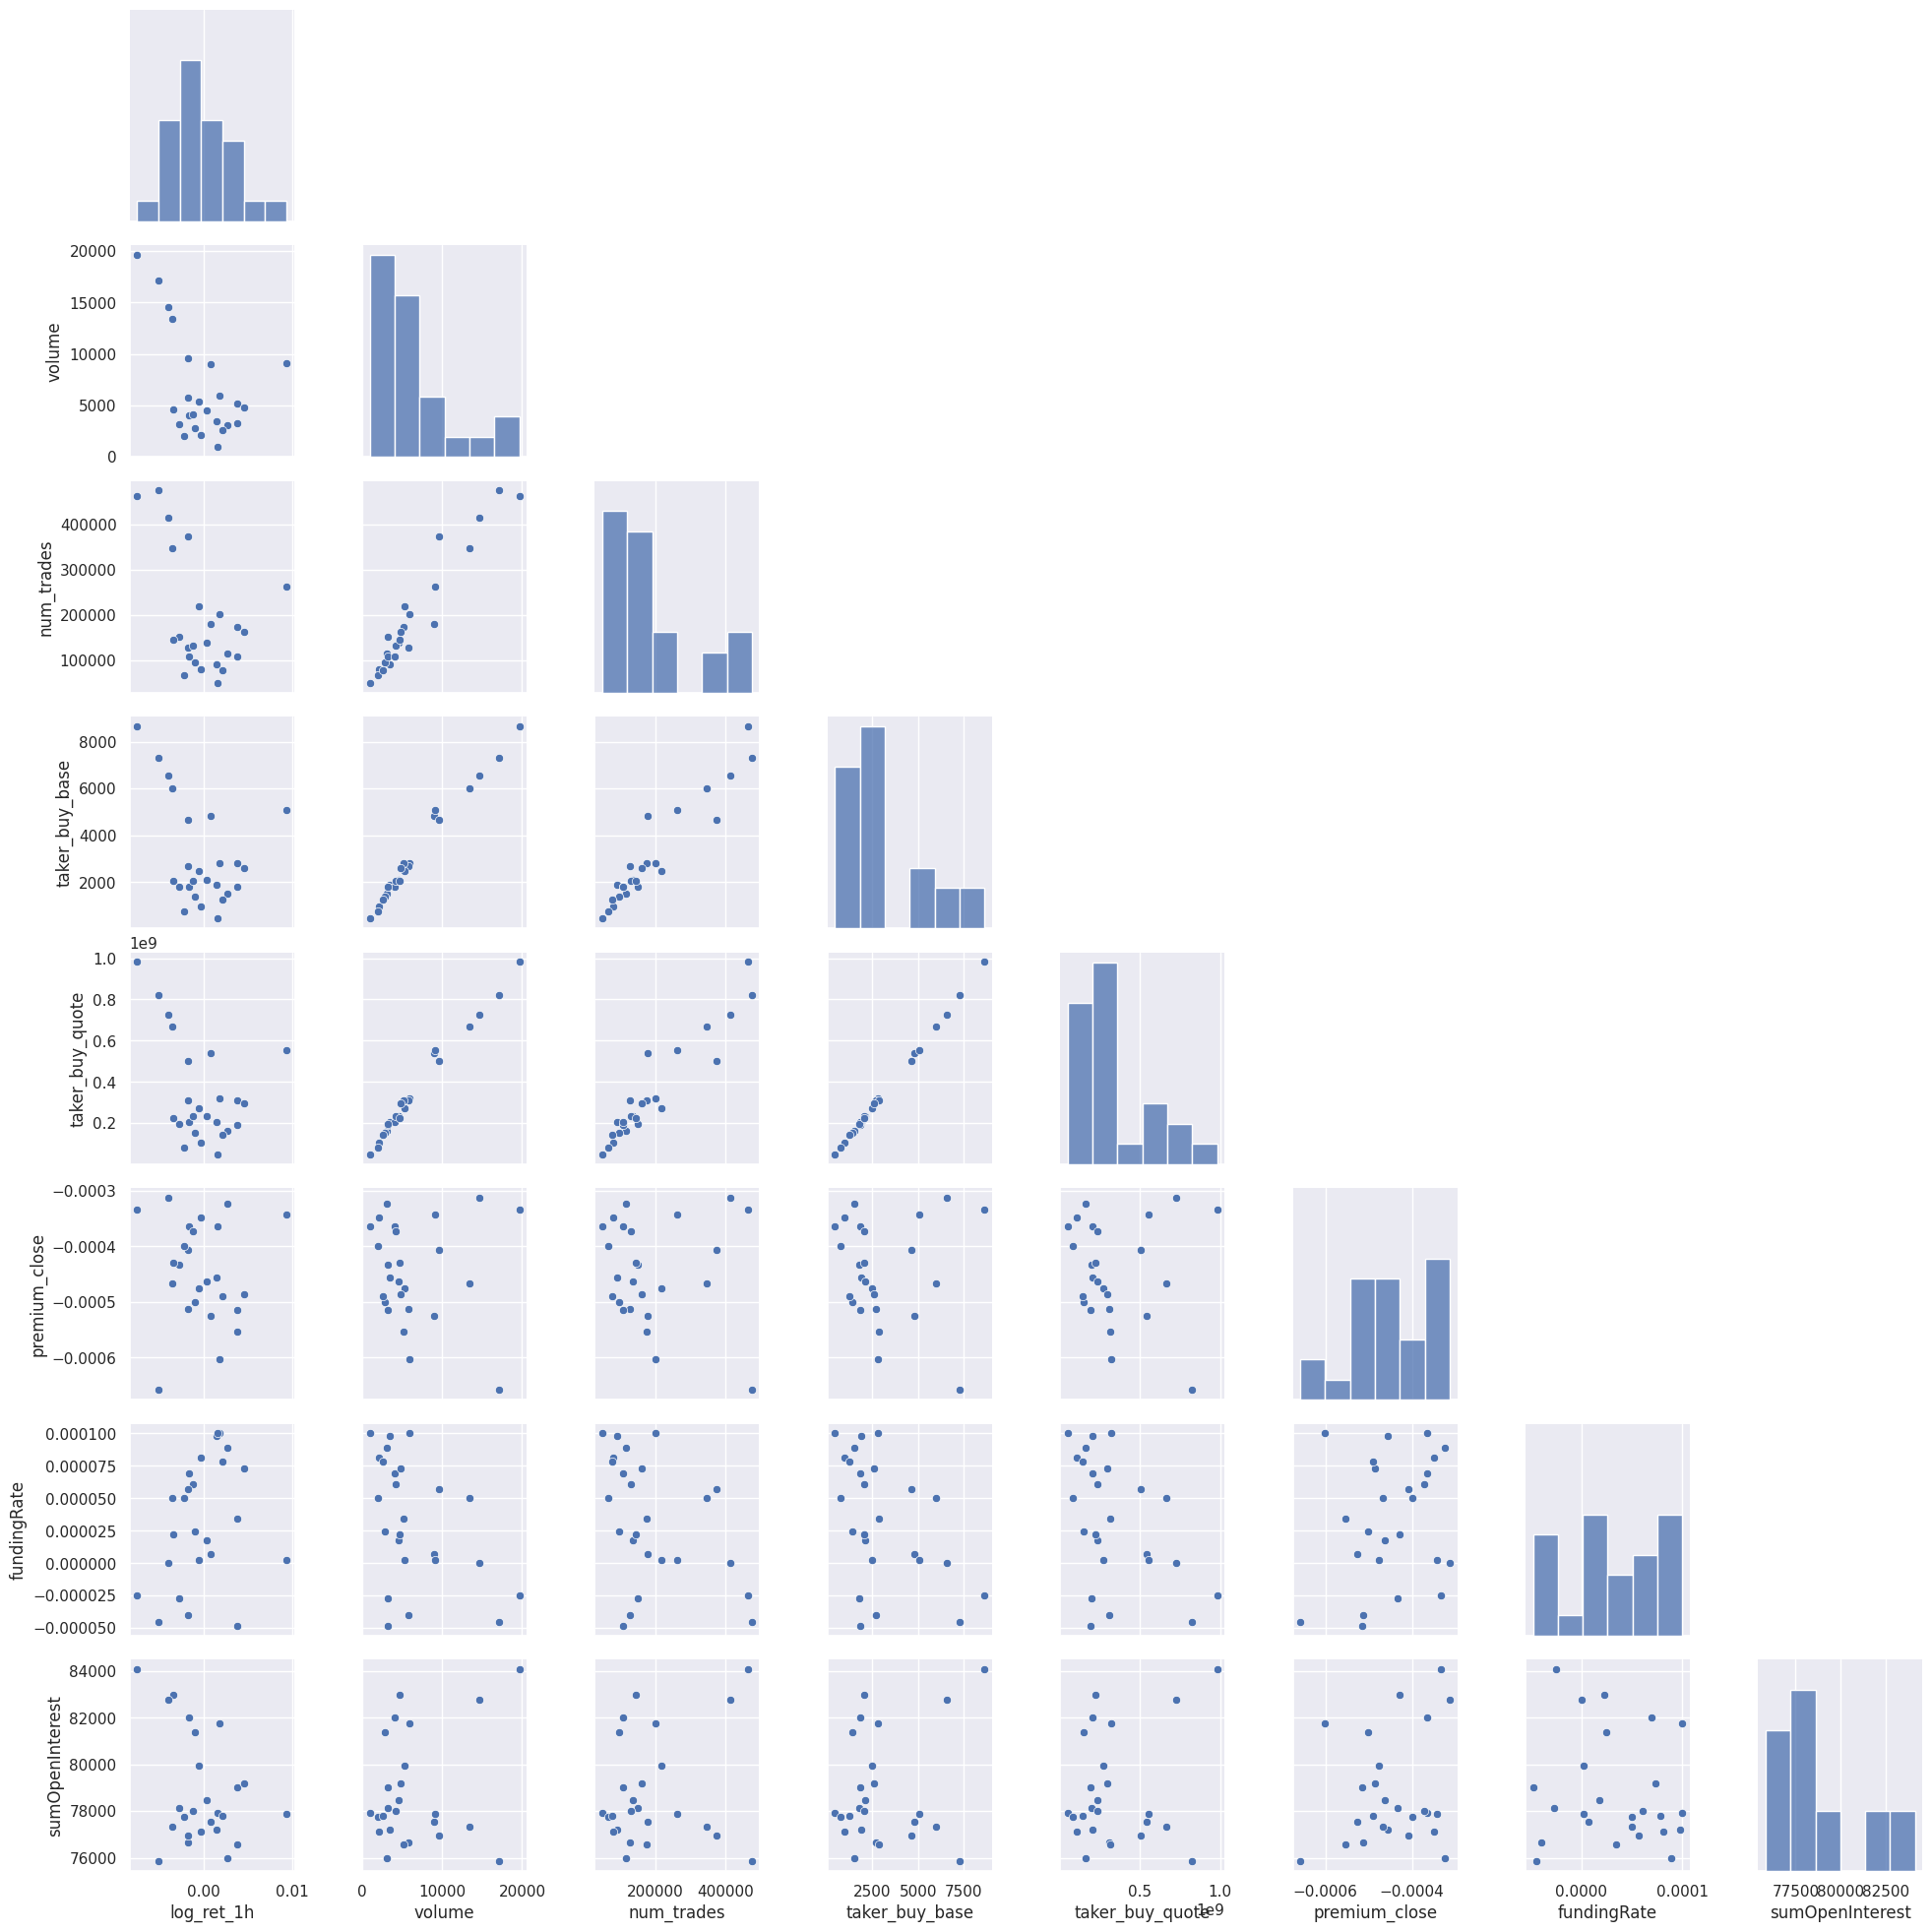

In [20]:

# Pairplot on a light subset (to keep it fast)
subset_cols = [c for c in ["log_ret_1h","volume","num_trades","taker_buy_base","taker_buy_quote","premium_close","fundingRate","sumOpenInterest"] if c in merged.columns]
tmp = merged[subset_cols].dropna().sample(n=min(2000, merged[subset_cols].dropna().shape[0]), random_state=42)
sns.pairplot(tmp, corner=True)


In [21]:
# Save merged for modeling step
OUT = "btcusdt_1h_merged.csv"

merged.to_csv(OUT, index=False)
print("Saved:", OUT)



Saved: btcusdt_1h_merged.csv
